<a href="https://colab.research.google.com/github/hamagami/preprocess/blob/main/06_02_water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import urllib.request 

url = "https://dl.dropbox.com/s/g8htb1fmd3uo24a/water_potability.csv"
urllib.request.urlretrieve(url, 'water_potability.csv') 

df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
#shape of the data
df.shape

(3276, 10)

There are 3276 rows and 10 columns

In [ ]:
#Check for missing values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
#Dropping missing values
#because water quality is a sensitive data, we cannot tamper with the data by imputing mean, median, mode
df= df.dropna()


In [ ]:
df.Potability.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

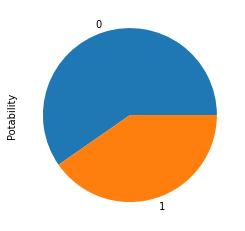

In [ ]:
#Plots
import matplotlib.pyplot as plt
import seaborn as sns


df.Potability.value_counts().plot(kind ='pie')

Thus it is an imbalanced dataset, since 0 is much more 1 (1998>1278)
So we need to balance the data so that there is no biasedness.

In [ ]:
zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
#minority class that  is 1, we need to upsample/increase that class so that there is no bias
#n_samples = 1998 means we want 1998 sample of class 1, since there are 1998 samples of class 0
df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 
#concatenate
df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence

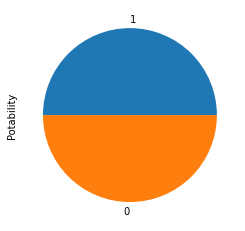

In [ ]:
df.Potability.value_counts().plot(kind ='pie')

Now it's perfect!

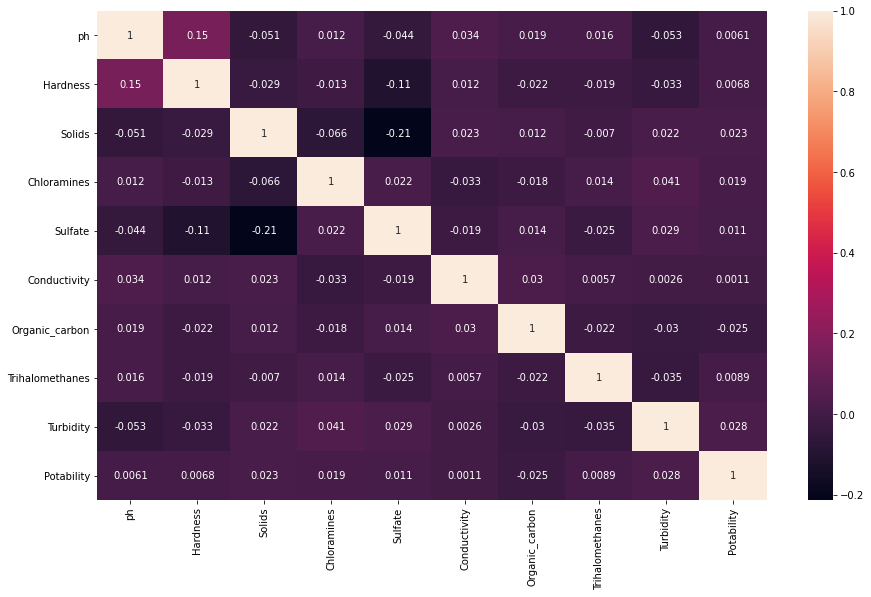

In [ ]:
#understanding correlation
plt.figure(figsize = (15,9))
sns.heatmap(df.corr(), annot = True)

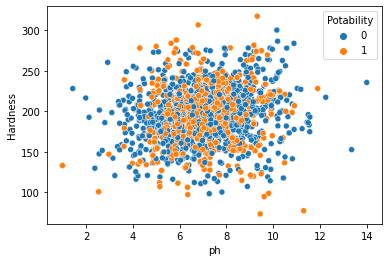

In [ ]:
sns.scatterplot(x=df["ph"], y=df["Hardness"], hue=df.Potability,
data=df)


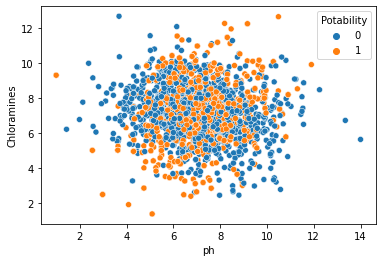

In [ ]:
sns.scatterplot(x=df["ph"], y=df["Chloramines"], hue=df.Potability,
data=df)

There is no particular pattern!

In [ ]:
df.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Turbidity          0.027715
Organic_carbon     0.024991
Solids             0.023159
Chloramines        0.018624
Sulfate            0.011273
Trihalomethanes    0.008883
Hardness           0.006832
ph                 0.006082
Conductivity       0.001082
Name: Potability, dtype: float64

highest correlation with Potability is solids with 5.24% only

In [ ]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

## Hyper-parameter Tuning ;)

In [ ]:
#Hyperparameter tuning ;)

lr = LogisticRegression(random_state=42)

knn = KNeighborsClassifier()

dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

ada = AdaBoostClassifier()

xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

nn = MLPClassifier()

para_knn = {'n_neighbors':np.arange(1, 50)}  #parameters of knn
grid_knn = GridSearchCV(knn, param_grid=para_knn, cv=5) #search knn for 5 fold cross validation

#parameters for decision tree
para_dt = {'criterion':['gini','entropy'],'max_depth':np.arange(1, 50), 'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}
grid_dt = GridSearchCV(dt, param_grid=para_dt, cv=5) #grid search decision tree for 5 fold cv
#"gini" for the Gini impurity and “entropy” for the information gain.
#min_samples_leaf: The minimum number of samples required to be at a leaf node, have the effect of smoothing the model

#parameters for random forest
#n_estimators: The number of trees in the forest.
params_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)

#parameters fpr AdaBoost
params_ada = {'n_estimators': [50,100,250,400,500,600], 'learning_rate': [0.2,0.5,0.8,1]}
grid_ada =  GridSearchCV(ada, param_grid=params_ada, cv=5)

#XGBoost
#parameters for xgboost
params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)

#params_nn

In [ ]:
grid_knn.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_ada.fit(X_train, y_train)
rs_xgb.fit(X_train, y_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

Best parameters for KNN: {'n_neighbors': 1}
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 46, 'min_samples_leaf': 1}
Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 350}
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 500}
Best parameters for XGBoost: {'n_estimators': 800, 'learning_rate': 0.2}


Wohohhhoooooo! We got the best parameters.

#### Applying bagging and boosting

In [ ]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=42, min_samples_leaf=1, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=42)
ada = AdaBoostClassifier(n_estimators= 600, learning_rate= 1 )
xgb = XGBClassifier(n_estimators= 250, learning_rate= 0.8)

#let's also apply bagging and boosting
bagging = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=46, min_samples_leaf=2, random_state=42),
                           n_estimators = 100, random_state = 42)
bagging.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=46,
                                                        min_samples_leaf=2,
                                                        random_state=42),
                  n_estimators=100, random_state=42)

In [ ]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada),
              ('Bagging Classifier', bagging), ('XGBoost', xgb)]


In [ ]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Logistic Regression : 0.51
K Nearest Neighbours : 0.79
Decision Tree : 0.81
Random Forest : 0.89
AdaBoost : 0.69
Bagging Classifier : 0.87
[13:58:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost : 0.83


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Random Forest has performed better.

In [ ]:
from sklearn.metrics import classification_report

y_pred_rf= rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89       116
           1       0.90      0.90      0.90       124

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



The precision of class 0 is 89% and that of class 1 is 90%
It means the model predicts 89% of class 0 and 90% of class 1 correctly

Accuracy is 89%

## Do upvote if you like it or fork it. This motivates us to produce more notebooks for the community.